# **COLLEGAMENTO AL DRIVE** 👌 ◀

In [1]:
from google.colab import drive
drive.mount('/content/drive')                                                   # Indirizzo base del drive

Mounted at /content/drive


# **LIBRERIE** 👌 ◀

In [2]:
!reset                                                # Forza il restart

In [3]:
# import the necessary packages
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

In [4]:
# import the necessary packages
from torch.nn import functional as F


In [5]:
# import the necessary packages
from torch.utils.data import Dataset
import cv2

In [6]:
import numpy as np                                    # Importa Numpy
import skimage.io as io                               # Importa il modulo Input/ouput di SK-Image
from skimage.transform import resize                  # Importa il modulo resize da SK-Image
from os import listdir                                # Importa il modulo listdir da OS

import matplotlib.pyplot as plt                       # Importa il modulo  pyplot di MatPlotLib

from PIL import Image                                 # Importa il modulo Image da PIL


In [7]:
from functools import lru_cache                       # Importa il modulo lru_cache da functools

In [8]:
!pip install segmentation-models-pytorch


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=b608805e16d503832a5e5a224404b79bb94060cce23ed67ff23925abce3fce8f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=f6fe346633f986fc9d86d14e4fcd518333668629017f755173b8d781b35ebcec
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [9]:
import torch
import segmentation_models_pytorch as smp
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

# **PATH** 👌 ◀

In [10]:
base_path = '/content/drive/MyDrive/'                                           # Path progetto
dataset_path = base_path + 'dataset/'                                           # Path dataset
model_path = base_path + '50Unet-pytorch/'                                     # Path del modello (cwd)
data_graph = model_path + 'grafici/'                                             # Path grafici
data_weights = model_path + 'pesi/'                                             # Path pesi

In [11]:
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = dataset_path+'0_train/'
MASK_DATASET_PATH = dataset_path+'0_train_bi/'


imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))


validImg = sorted(list(paths.list_images('/content/drive/MyDrive/dataset/2_test/')))
validMask = sorted(list(paths.list_images('/content/drive/MyDrive/dataset/2_test_bi/')))

In [12]:
# Check if the validation image directory exists and contains files
if os.path.exists('/content/drive/MyDrive/dataset/2_test/') and len(os.listdir('/content/drive/MyDrive/dataset/2_test/')) > 0:
    print("Validation image directory exists and is not empty.")
else:
    print("Validation image directory is either missing or empty. Please check the path.")

# Do the same for the mask directory
if os.path.exists('/content/drive/MyDrive/dataset/2_test_bi/') and len(os.listdir('/content/drive/MyDrive/dataset/2_test_bi/')) > 0:
    print("Validation mask directory exists and is not empty.")
else:
    print("Validation mask directory is either missing or empty. Please check the path.")

Validation image directory exists and is not empty.
Validation mask directory exists and is not empty.


# **ISTANZIAMENTO RETE** 👌 ◀

In [13]:

'''
parametri ignorati/non visibili con pytorch ma settabili con keras
                weights=None,
                encoder_features='default',
                decoder_block_type='upsampling',
                decoder_filters=(256, 128, 64, 32, 16),
                decoder_use_batchnorm=True
'''

# Definizione della rete Unet con backbone ResNet18
BACKBONE = 'resnet50'

model = smp.Unet(
    encoder_name=BACKBONE,                            # Modello utilizzato come estrattore di feature
    encoder_weights=None,                             # Pre-formazione: nessuna
    in_channels=3,                                    # Input con 3 canali (immagini RGB)
    classes=1,                                        # Numero di classi di output (1 per segmentazione binaria)
    activation='sigmoid'                              # Output tra [0, 1] per stabilità nel training
)

# # Congelamento dei pesi del backbone
# for param in model.encoder.parameters():
#     param.requires_grad = False

# Definizione della funzione di perdita (binary cross-entropy)
loss_fn = nn.BCELoss()

# Ottimizzatore (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.06)


# Funzione di training
def train(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    total_iou = 0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, masks)

        # Backward pass e ottimizzazione
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # update our training history

    return total_loss / len(dataloader)


def validate(model, dataloader, loss_fn, device):
    # initialize the validation loss
    total_loss = 0
    loss = 0
    # turn on evaluation mode
    model.eval()
    # switch off autograd
    with torch.no_grad():
      # loop over the validation set
      for (x, y) in validLoader:
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # make the predictions and calculate the validation loss
        pred = model(x)
        loss += loss_fn(pred, y)
        total_loss += loss.item()
        # update our training history
    return total_loss / len(dataloader)


# Inizializzazione del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [14]:
# Esempio di DataLoader (da riempire con dataset specifico)
from google.colab.patches import cv2_imshow
class SegmentationDataset(Dataset):

  def __init__(self, image_path, mask_path, transform=None):
    """
    Arguments:
        image_path (string):
        mask_path (string):
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.image_path = image_path
    self.mask_path = mask_path
    self.transforms = transform


  def __len__(self):
    # return the number of total samples contained in the dataset
    return len(self.image_path)


  def __getitem__(self, idx):
    # grab the image path from the current index
    imagePath = self.image_path[idx]
    # load the image from disk, swap its channels from BGR to RGB,
    # and read the associated mask from disk in grayscale mode
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(self.mask_path[idx], 0)
    # check to see if we are applying any transformations
    if self.transforms is not None:
      # apply the transformations to both image and its mask
      image = self.transforms(image)
      mask = self.transforms(mask)

    # return a tuple of the image and its mask
    return (image, mask)


    def show_item(self, idx):
      # grab the image path from the current index
      imagePath = self.image_path[idx]
      # load the image from disk, swap its channels from BGR to RGB,
      # and read the associated mask from disk in grayscale mode
      image = cv2.imread(imagePath)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      mask = cv2.imread(self.mask_path[idx], 0)
      # check to see if we are applying any transformations
      if self.transforms is not None:
        # apply the transformations to both image and its mask
        image = self.transforms(image)
        mask = self.transforms(mask)

      image = image.permute(1, 2, 0)
      mask = mask.permute(1, 2, 0)

      print(image.shape)
      print(mask.shape)
      print(image.type)
      print(mask.type)
      # Display the image
      cv2_imshow(np.array(image))
      cv2_imshow(np.array(mask))




In [15]:

#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
#https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html
from torchvision.transforms import InterpolationMode, Compose, ToPILImage, Resize, ToTensor, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation

# define transformations
transformations = Compose([
    ToPILImage(),
 	  Resize((256,256),interpolation=InterpolationMode.NEAREST),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    RandomRotation(degrees=10),
    ToTensor()
    ])

transformed_dataset_train = SegmentationDataset(image_path=imagePaths,
                                           mask_path=maskPaths,
                                           transform=transformations
                                           )



transformed_dataset_valid = SegmentationDataset(image_path=validImg,
                                           mask_path=validMask,
                                           transform=transformations
                                           )

print(f"[INFO] found {len(transformed_dataset_train)} examples in the training set...")
print(f"[INFO] found {len(transformed_dataset_valid)} examples in the validation set...")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

#https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(
    transformed_dataset_train,
    batch_size=5,
    shuffle=True,
    pin_memory=PIN_MEMORY,
    num_workers=os.cpu_count()
    )

validLoader = DataLoader(
    transformed_dataset_valid,
    batch_size=5,
    shuffle=False,
    pin_memory=PIN_MEMORY,
    num_workers=os.cpu_count()
    )


[INFO] found 1531 examples in the training set...
[INFO] found 202 examples in the validation set...


In [16]:
#transformed_dataset.show_item(0) #da aggiustare



# **TRAIN** 👌

In [ ]:
#first train
num_epochs = 1

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    print(f"Epoch {epoch}: Loss = {train_loss}")

    # Salva l'intero modello per ogni epoca
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss
                }, data_weights + 'epoca-' + str(epoch) + '.pth')

    with open( data_graph + 'train_loss.npy', 'ab') as f:             # ab = append binary
      np.save(f, train_loss)



Epoch 0: Loss = 0.05740641442458191


In [43]:
#next trainings
PATH = '/content/drive/MyDrive/50Unet-pytorch/pesi/epoca-86.pth'

checkpoint = torch.load(PATH, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']
print(last_epoch,last_loss)

num_epochs = 200

for epoch in range(last_epoch+1, num_epochs):

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    print(f"Epoch {epoch}: Loss = {train_loss}")

    # Salva l'intero modello per ogni epoca
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss
                }, data_weights + 'epoca-' + str(epoch) + '.pth')



    valid_loss = validate(model, validLoader, loss_fn, device)
    print(f"\tEpoch {epoch}: Validation Loss = {valid_loss}")



86 0.038003445147909834
Epoch 87: Loss = 0.03782682288862789
	Epoch 87: Validation Loss = 0.8117298535184889
Epoch 88: Loss = 0.037668062122204984
	Epoch 88: Validation Loss = 0.8166956004300495
Epoch 89: Loss = 0.03743620544174498
	Epoch 89: Validation Loss = 0.8085813687251109
Epoch 90: Loss = 0.03781182816440197
	Epoch 90: Validation Loss = 0.8012868886495509
Epoch 91: Loss = 0.037825346429883853
	Epoch 91: Validation Loss = 0.8007715216769677
Epoch 92: Loss = 0.03740094263858923
	Epoch 92: Validation Loss = 0.8045163498964252
Epoch 93: Loss = 0.03763503581285477
	Epoch 93: Validation Loss = 0.8051097885046791
Epoch 94: Loss = 0.037459405181559366
	Epoch 94: Validation Loss = 0.7900372569153948
Epoch 95: Loss = 0.03775836479416305
	Epoch 95: Validation Loss = 0.799371842612944
Epoch 96: Loss = 0.0375562956168374
	Epoch 96: Validation Loss = 0.7992229279039836
Epoch 97: Loss = 0.03741065626326912
	Epoch 97: Validation Loss = 0.8469314661058711
Epoch 98: Loss = 0.03734458332838861
	Ep

KeyboardInterrupt: 

# **TEST** 👌

In [18]:
# Funzione per calcolare la precision
def precision(mask_img, predicted_img, treshold):
  tp = np.sum((mask_img > treshold) & (predicted_img > treshold))   #entrambi veri
  fp = np.sum( (mask_img < treshold) & (predicted_img > treshold) )   #è vera solo la predetta
  return tp / (tp + fp + 1e-10)

# Funzione per calcolare la recall
def recall(mask_img, predicted_img, treshold):
  tp = np.sum((mask_img > treshold) & (predicted_img > treshold))   #entrambi veri
  fn = np.sum( (mask_img > treshold) & (predicted_img < treshold) )   #è vera solo la mask
  return tp / (tp + fn + 1e-10)

# Funzione per calcolare la F1-score
def f1_score(mask_img, predicted_img, treshold):
  precision_value = precision(mask_img, predicted_img, treshold)
  recall_value = recall(mask_img, predicted_img, treshold)
  return 2 * (precision_value * recall_value) / (precision_value + recall_value + 1e-10)

# Funzione per calcolare l'Intersection over Union (IoU)
def iou(mask_img, predicted_img, treshold):
  tp = np.sum((mask_img > treshold) & (predicted_img > treshold))   #entrambi veri
  fp = np.sum( (mask_img < treshold) & (predicted_img > treshold) )   #è vera solo la predetta
  fn = np.sum( (mask_img > treshold) & (predicted_img < treshold) )   #è vera solo la mask
  return tp / (tp + fp + fn + 1e-10)

In [54]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()
	print("\n")

def make_predictions(model, imagePath, maskPath, device, threshold):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (256, 256))
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(maskPath,filename)
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
		#print(groundTruthPath)
		gtMask = cv2.resize(gtMask, (256, 256))
    # make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(device)

		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
		#print(predMask)

		# filter out the weak predictions and convert them to integers
		predMask = (predMask > threshold)

		return orig, gtMask, predMask


def random_test_evaluation(model, number_of_images, threshold):

	# load the image paths in our testing file and randomly select n image paths
	IMAGE_TEST_PATH = '/content/drive/MyDrive/dataset/2_test/'
	MASK_TEST_PATH = '/content/drive/MyDrive/dataset/2_test_bi/'
	image_paths = [os.path.join(IMAGE_TEST_PATH, f) for f in os.listdir(IMAGE_TEST_PATH) if os.path.isfile(os.path.join(IMAGE_TEST_PATH, f))]
	imagePaths = np.random.choice(image_paths, size=number_of_images)

	#threshold = 0.5

	# iterate over the randomly selected test image paths
	for path in imagePaths:

		print(path)

		# make predictions
		orig, gtMask, predMask = make_predictions(model, path, MASK_TEST_PATH, torch.device("cuda" if torch.cuda.is_available() else "cpu"), threshold)

		print(f"Precision: {precision(gtMask, predMask, threshold)}")
		print(f"Recall: {recall(gtMask, predMask, threshold)}")
		print(f"F1-Score: {f1_score(gtMask, predMask, threshold)}")
		print(f"IoU: {iou(gtMask, predMask, threshold)}")

		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)



def full_test_evaluation(model, treshold):

	# load the image paths in our testing file and randomly select n image paths
	IMAGE_TEST_PATH = '/content/drive/MyDrive/dataset/2_test/'
	MASK_TEST_PATH = '/content/drive/MyDrive/dataset/2_test_bi/'
	#imagePaths = [os.path.join(IMAGE_TEST_PATH, f) for f in os.listdir(IMAGE_TEST_PATH) if os.path.isfile(os.path.join(IMAGE_TEST_PATH, f))]
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

	precision_list = []
	recall_list = []
	f1_list = []
	iou_list = []
	#treshold = 0.1

	# iterate over the test image paths: 202 images
	for path in os.listdir(IMAGE_TEST_PATH):

		# make predictions
		orig, gtMask, predMask = make_predictions(model, os.path.join(IMAGE_TEST_PATH, path), MASK_TEST_PATH, device, treshold)

		precision_list.append(precision(gtMask, predMask, treshold))
		recall_list.append(recall(gtMask, predMask, treshold))
		f1_list.append(f1_score(gtMask, predMask, treshold))
		iou_list.append(iou(gtMask, predMask, treshold))

	#salva ciscuna lista in file npy
	data_graph = '/content/drive/MyDrive/50Unet-pytorch/grafici/'
	with open(data_graph + 'precision_list.npy', 'wb') as f:
			np.save(f, np.array(precision_list))
	with open(data_graph + 'recall_list.npy', 'wb') as f:
			np.save(f, np.array(recall_list))
	with open(data_graph + 'f1_list.npy', 'wb') as f:
			np.save(f, np.array(f1_list))
	with open(data_graph + 'iou_list.npy', 'wb') as f:
			np.save(f, np.array(iou_list))

	return np.mean(precision_list), np.mean(recall_list), np.mean(f1_list), np.mean(iou_list)




def random_test_evaluation_t(model, number_of_images):

	# load the image paths in our testing file and randomly select n image paths
	IMAGE_TEST_PATH = '/content/drive/MyDrive/dataset/2_test/'
	MASK_TEST_PATH = '/content/drive/MyDrive/dataset/2_test_bi/'
	image_paths = [os.path.join(IMAGE_TEST_PATH, f) for f in os.listdir(IMAGE_TEST_PATH) if os.path.isfile(os.path.join(IMAGE_TEST_PATH, f))]
	imagePaths = np.random.choice(image_paths, size=number_of_images)

	threshold_list = [0.2,
	                  0.500,
										0.505,
			 							0.501,
	                  0.502,
										0.503,
										0.504,
										0.505,
										0.506,
										0.507,
										0.508,
										0.509,
										0.6
										]

	# iterate over the randomly selected test image paths
	for path in imagePaths:

		print(path)
		for threshold in threshold_list:
			# make predictions
			orig, gtMask, predMask = make_predictions(model, path, MASK_TEST_PATH, torch.device("cuda" if torch.cuda.is_available() else "cpu"), threshold)

			print(threshold)
			print(f"Precision: {precision(gtMask, predMask, threshold)}")
			print(f"Recall: {recall(gtMask, predMask, threshold)}")
			print(f"F1-Score: {f1_score(gtMask, predMask, threshold)}")
			print(f"IoU: {iou(gtMask, predMask, threshold)}")

			# prepare a plot for visualization
			prepare_plot(orig, gtMask, predMask)


## 3 std images evaluation

In [48]:

def _4_random_test_evaluation(model, number_of_images, threshold):

  # load the image paths in our testing file and randomly select n image paths
  IMAGE_TEST_PATH = '/content/drive/MyDrive/dataset/2_test/'
  MASK_TEST_PATH = '/content/drive/MyDrive/dataset/2_test_bi/'
  names = ['01104.jpg','00007.jpg','01925.jpg','01760.jpg']
  imagePaths = [os.path.join(IMAGE_TEST_PATH, f) for f in names if os.path.isfile(os.path.join(IMAGE_TEST_PATH, f))]

  # iterate over the randomly selected test image paths
  for path in imagePaths:

    print(path)

    # make predictions
    orig, gtMask, predMask = make_predictions(model, path, MASK_TEST_PATH, torch.device("cuda" if torch.cuda.is_available() else "cpu"), threshold)

    print(f"Precision: {precision(gtMask, predMask, threshold)}")
    print(f"Recall: {recall(gtMask, predMask, threshold)}")
    print(f"F1-Score: {f1_score(gtMask, predMask, threshold)}")
    print(f"IoU: {iou(gtMask, predMask, threshold)}")

    # prepare a plot for visualization
    prepare_plot(orig, gtMask, predMask)



<ipython-input-52-686bd56a67d2>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))


/content/drive/MyDrive/dataset/2_test/01104.jpg
Precision: 0.37957824639285465
Recall: 0.32853025936596264
F1-Score: 0.35221421210264375
IoU: 0.21374999999998665


/content/drive/MyDrive/dataset/2_test/00007.jpg
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
IoU: 0.0


/content/drive/MyDrive/dataset/2_test/01925.jpg
Precision: 0.028417533432391746
Recall: 0.23757763975151588
F1-Score: 0.050763105488545145
IoU: 0.026042553191488918


/content/drive/MyDrive/dataset/2_test/01760.jpg
Precision: 0.17693137903422285
Recall: 0.7020306672192195
F1-Score: 0.2826316667272004
IoU: 0.1645725388601031




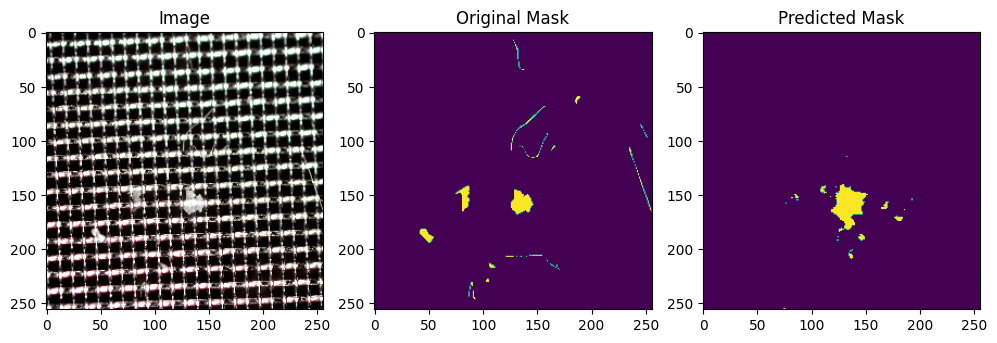

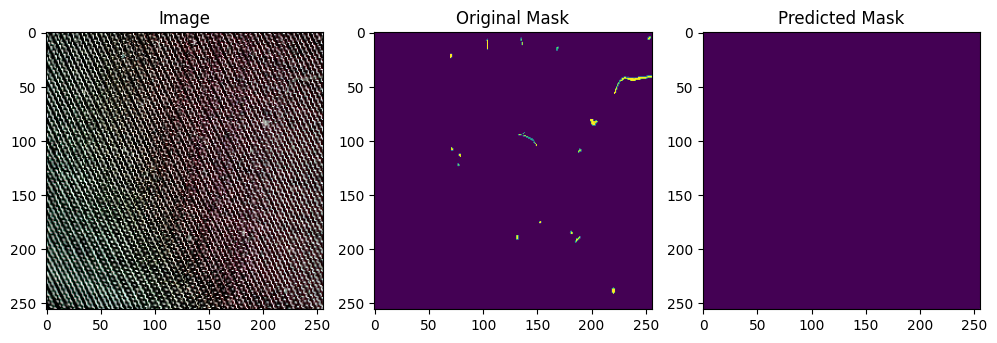

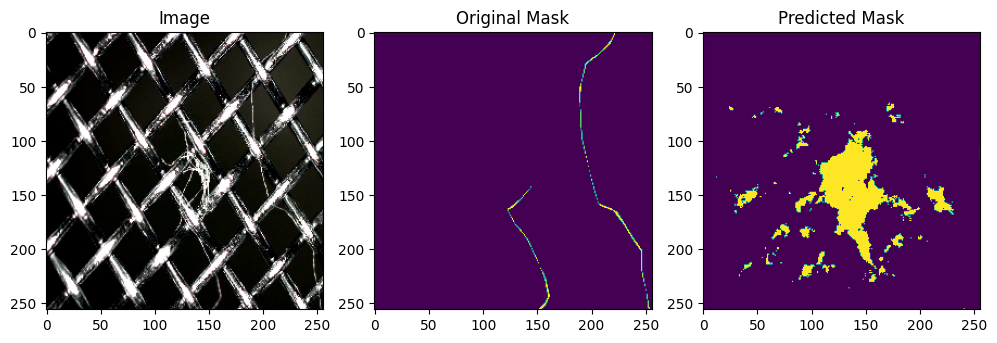

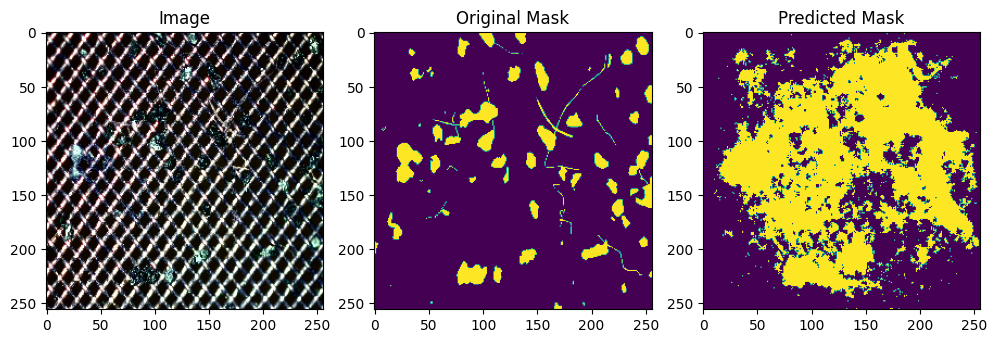

In [52]:
#USAGE random_test_evaluation

# load our model from disk and flash it to the current device
MODEL_PATH = '/content/drive/MyDrive/50Unet-pytorch/pesi/epoca-101.pth'
checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']
#print(last_epoch,last_loss)

t = 0.505

_4_random_test_evaluation(model,1,t)

## tests

In [ ]:
#USAGE random_test_evaluation

# load our model from disk and flash it to the current device
MODEL_PATH = '/content/drive/MyDrive/ResUnet-pytorch/pesi/epoca-145.pth'
checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']
#print(last_epoch,last_loss)

t = 0.504

random_test_evaluation(model,1,t)

In [47]:
#USAGE full_test_evaluation

# load our model from disk and flash it to the current device
MODEL_PATH = '/content/drive/MyDrive/50Unet-pytorch/pesi/epoca-101.pth'
checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']
#print(last_epoch,last_loss)

t=0.505

precision_mean, recall_mean, f1_mean, mIoU = full_test_evaluation(model, t)
print(f"Precision mean: {precision_mean}")
print(f"Recall mean: {recall_mean}")
print(f"F1-Score mean: {f1_mean}")
print(f"mIoU: {mIoU}")

<ipython-input-47-049046ce9d2d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))


Precision mean: 0.07449732640277591
Recall mean: 0.1619455612937252
F1-Score mean: 0.04881501545064177
mIoU: 0.029598190820454562


In [ ]:
#USAGE treshold

# load our model from disk and flash it to the current device
MODEL_PATH = '/content/drive/MyDrive/50Unet-pytorch/pesi/epoca-72.pth'
checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']
#print(last_epoch,last_loss)


random_test_evaluation_t(model,1)

In [ ]:
#overfitting

def overfitting_check(model, treshold):

	# load the image paths in our testing file and randomly select n image paths
  IMAGE_TEST_PATH = '/content/drive/MyDrive/dataset/0_train/'
  MASK_TEST_PATH = '/content/drive/MyDrive/dataset/0_train_bi/'
  #imagePaths = [os.path.join(IMAGE_TEST_PATH, f) for f in os.listdir(IMAGE_TEST_PATH) if os.path.isfile(os.path.join(IMAGE_TEST_PATH, f))]
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  image_paths = os.listdir(IMAGE_TEST_PATH)
  imagePaths = np.random.choice(image_paths, size=202)

  precision_list = []
  recall_list = []
  f1_list = []
  iou_list = []

  #treshold = 0.1

  # iterate over the test image paths: 202 images
  for path in imagePaths:

    # make predictions
    orig, gtMask, predMask = make_predictions(model, os.path.join(IMAGE_TEST_PATH, path), MASK_TEST_PATH, device, treshold)

    precision_list.append(precision(gtMask, predMask, treshold))
    recall_list.append(recall(gtMask, predMask, treshold))
    f1_list.append(f1_score(gtMask, predMask, treshold))
    iou_list.append(iou(gtMask, predMask, treshold))

  #salva ciscuna lista in file npy
  data_graph = '/content/drive/MyDrive/ResUnet-pytorch/grafici/'
  with open(data_graph + 'precision_list_train.npy', 'wb') as f:
      np.save(f, np.array(precision_list))
  with open(data_graph + 'recall_list_train.npy', 'wb') as f:
      np.save(f, np.array(recall_list))
  with open(data_graph + 'f1_list_train.npy', 'wb') as f:
      np.save(f, np.array(f1_list))
  with open(data_graph + 'iou_list_train.npy', 'wb') as f:
      np.save(f, np.array(iou_list))

  return np.mean(precision_list), np.mean(recall_list), np.mean(f1_list), np.mean(iou_list)



#USAGE full_test_evaluation

# load our model from disk and flash it to the current device
MODEL_PATH = '/content/drive/MyDrive/ResUnet-pytorch/pesi/epoca-95.pth'
checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']
#print(last_epoch,last_loss)

t = 0.5

precision_mean, recall_mean, f1_mean, mIoU = overfitting_check(model,t)
print(f"Precision mean: {precision_mean}")
print(f"Recall mean: {recall_mean}")
print(f"F1-Score mean: {f1_mean}")
print(f"mIoU: {mIoU}")

<ipython-input-32-ce1b5a5a9cd6>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))


Precision mean: 0.009968974802753654
Recall mean: 0.4975247524744009
F1-Score mean: 0.018013777205906707
mIoU: 0.00943541688853294


# GRAFICI

In [44]:
loss_list = []
for i in range(86,102):
  MODEL_PATH = f'/content/drive/MyDrive/50Unet-pytorch/pesi/epoca-{str(i)}.pth'
  checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cuda'))
  last_loss = checkpoint['loss']
  loss_list.append(last_loss)
  print(last_loss)

with open( data_graph + 'NEW_loss_list2.npy', 'wb') as f:             # ab = append binary
  np.save(f, loss_list)

<ipython-input-44-ea8bf2d54d7d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cuda'))


0.038003445147909834
0.03782682288862789
0.037668062122204984
0.03743620544174498
0.03781182816440197
0.037825346429883853
0.03740094263858923
0.03763503581285477
0.037459405181559366
0.03775836479416305
0.0375562956168374
0.03741065626326912
0.03734458332838861
0.037183460922068416
0.03755831364420901
0.03719999904801966


**GRAFICI MEDIA ARITMETICA**

In [45]:

loss_t1 = np.load(data_graph + 'NEW_loss_list.npy')

loss_t2 = np.load(data_graph + 'NEW_loss_list2.npy')

loss_t = np.concatenate((loss_t1, loss_t2))
print(loss_t.shape)

(103,)


<Figure size 1000x500 with 0 Axes>

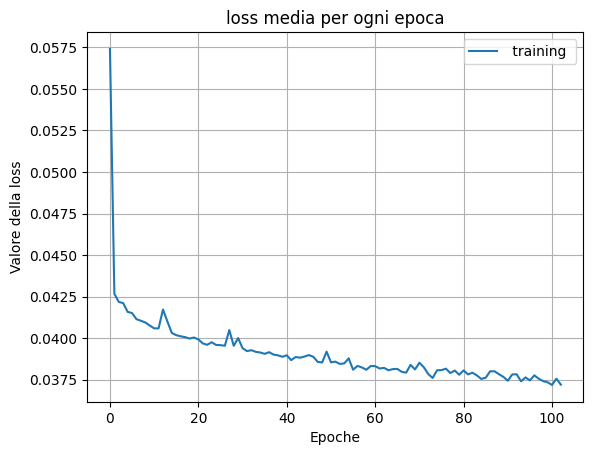

In [46]:
fig = plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
plt.title('loss media per ogni epoca')

plt.xlabel('Epoche')
plt.ylabel('Valore della loss')


ax.plot(loss_t, label = ' training ')

# Legenda del plot
plt.legend()
plt.grid()

#fig.savefig(data_graph + 'metriche.png', bbox_inches='tight',  dpi=100)

## **GRAFICI MEDIA ARITMETICA**

(202,)


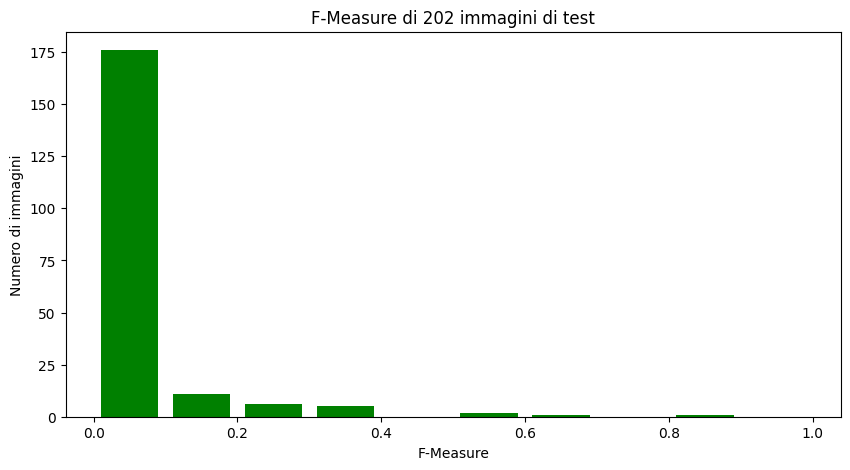

In [55]:
f1 = np.load('/content/drive/MyDrive/ResUnet-pytorch/grafici/f1_list.npy')
print(f1.shape)

fig = plt.figure(figsize=(10,5))

# Set del range di osservazione e del numero di intervalli
value = (0, 1)      # Media aritmetica
bins = 10

# Plot di un istogramma
plt.hist(f1, bins, value, color = 'green', histtype = 'bar', rwidth = 0.8)

# Etichetta asse x
plt.xlabel('F-Measure')
# Etichetta asse y
plt.ylabel('Numero di immagini')
# Titolo del plot
plt.title('F-Measure di 202 immagini di test')

#fig.savefig(data_graph + 'fm.png', bbox_inches='tight', dpi=100)

# Funzione per mostrare il plot
plt.show()

(202,)


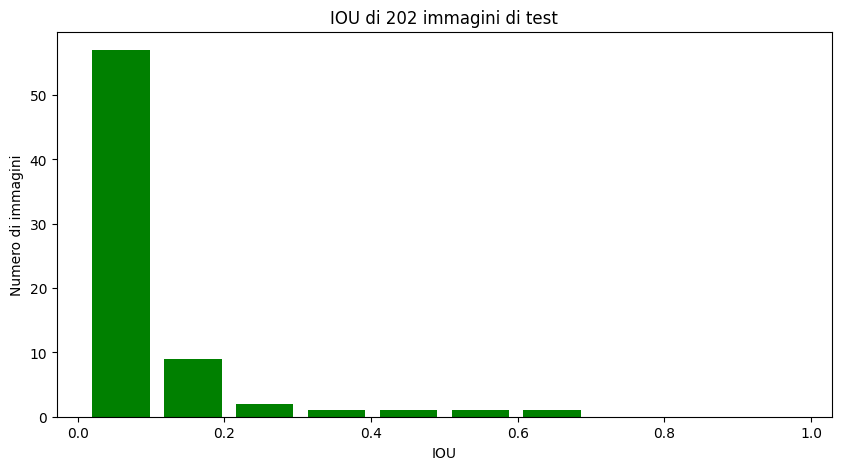

In [57]:
iou = np.load(data_graph + 'iou_list.npy')
iou = np.load('/content/drive/MyDrive/ResUnet-pytorch/grafici/iou_list.npy')

print(iou.shape)

fig = plt.figure(figsize=(10,5))

# Set del range di osservazione e del numero di intervalli
value = (0, 1)      # Media aritmetica
bins = 10

# Plot di un istogramma
plt.hist(iou, bins, value, color = 'green', histtype = 'bar', rwidth = 0.8)

# Etichetta asse x
plt.xlabel('IOU')
# Etichetta asse y
plt.ylabel('Numero di immagini')
# Titolo del plot
plt.title('IOU di 202 immagini di test')

#fig.savefig(data_graph + 'fm.png', bbox_inches='tight', dpi=100)

# Funzione per mostrare il plot
plt.show()